# Homework

In this portion of the Problem Set, you will gain experience building a CNN for image
classification on the MNIST dataset -- a true rite of passage for deep learning and computer
vision! Your code should follow this general outline:


### 1. Download the data. Implement a data loader class to load the dataset. (5 points)

In [64]:
import numpy as np 
import matplotlib.pyplot as plt

#PyTorch - Importing the Libraries
import torch
import torch.nn as nn
import torchvision               #主要用来构建计算机视觉模型
import torchvision.transforms    #用来对图像进行变换(裁切，旋转之类)

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./traindata/', train=True, transform=transforms, download=True)  
test_dataset = torchvision.datasets.MNIST(root='./testdata/',train=False, transform=transforms, download=True)  
device = 'cuba' if torch.cuda.is_available()  else 'cpu'
print('Using {} device'.format(device))

Using cuba device


tensor(5)


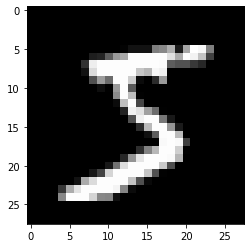

In [65]:
# Loading the Data
def imshowPytorch(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # H x W x color_channel
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32, 
                                           shuffle=False)
                                           
data_iter = iter(train_loader)
images, label = next(data_iter)  # images are 32 x 1 x 28 x 28
imshowPytorch(torchvision.utils.make_grid(images[0]))
print(label[0])

### 2. Define the model. We suggest you start with 3 convolutional layers with 24, 48, 64 filters/feature maps, respectively. Each convolutional layer will have 5x5 filters with 2x2 pooling and ReLu activation. Finally, use a fully connected layer to map features to output. (10 points)


In [66]:
#PyTorch - Building the Model
class NeuralNet(nn.Module):
    def __init__(self, num_of_class):
        super(NeuralNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(24, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(48, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(64*3*3,84),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(84, num_of_class)

    def forward(self, x):
        x = self.cnn_model(x)  # BS x 64 x 5 x 5
        x = x.view(-1,64*3*3)  # 64 x 5 x 5 --> 1600 x 1    
        x = self.fc_model(x)
        x = self.classifier(x)
        return x

In [67]:
#PyTorch - Visualizing the Model
modelpy = NeuralNet(10)
modelpy

NeuralNet(
  (cnn_model): Sequential(
    (0): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=576, out_features=84, bias=True)
    (1): ReLU()
  )
  (classifier): Linear(in_features=84, out_features=10, bias=True)
)

### 3. Utilize a gradient-based optimizer. (5 points)


In [68]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(modelpy.parameters())

### 4. Train the model! (10 points)


In [72]:
# Training the Model
losses_his = torch.zeros(6)
for e in range(5):
    # define the loss value after the epoch
    losss = 0.0
    number_of_sub_epoch = 0
    # loop for every training batch (one epoch)
    for images, labels in train_loader:
        #create the output from the network
        out = modelpy(images)
        # count the loss function
        loss = criterion(out, labels)
        # in pytorch you have assign the zero for gradien in any sub epoch
        optim.zero_grad()
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        # add new value to the main loss
        losss += loss.item()
        number_of_sub_epoch += 1
    print("Epoch {}: Loss: {}".format(e, losss / number_of_sub_epoch))
    losses_his[e+1] = losss / number_of_sub_epoch

Epoch 0: Loss: 0.02256391446536812
Epoch 1: Loss: 0.01809207120934831
Epoch 2: Loss: 0.01566509108557163
Epoch 3: Loss: 0.013585946904757914
Epoch 4: Loss: 0.012123279227473843


### 5. Evaluate the trained model on an independent test set. What was its performance? What accuracy did your model achieve, and anything in particular that it had trouble with? (10 points)

In [73]:
#PyTorch - Comparing the Results
correct = 0
total = 0
modelpy.eval()  # all of your layers are in eval stage, important for layers such as batchnorm or dropout --> will mess up the result if the network has batchnorm or dropout layers, e.g. RESNET

with torch.no_grad(): # all of computation graphs will not update gradients because we will not do any backpropagation --> speed up, doesn't hurt if not called
  for images, labels in test_loader:
      outputs = modelpy(images)
      _, predicted = torch.max(outputs.data, 1)  # outputs.data in shape of BS x 10  -->  BS x 1
      total += labels.size(0)
      correct += (predicted == labels).sum()
print('Test Accuracy of the model on the {} test images: {}%'.format(total, 100 * correct // total))


Test Accuracy of the model on the 10000 test images: 99%


### **6. Provide a summary of any architectural modifications made, plots of the loss evolution from (4), and plots of your results from (5). Please save your code and results for submission. (20 points)**

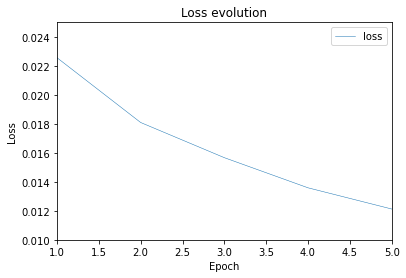

Test Accuracy of the model on the 10000 test images: 99%


In [84]:
plt.plot(losses_his,label='loss',lw=0.5)
plt.legend(loc='best')
plt.title('Loss evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.01,0.025)
plt.xlim(1,5)
plt.show()
print('Test Accuracy of the model on the {} test images: {}%'.format(total, 100 * correct // total))